In [2]:
import pymc3 as pm
import arviz as az
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
palette = 'muted'
sns.set_palette(palette); sns.set_color_codes(palette)

AttributeError: partially initialized module 'theano' has no attribute 'compile' (most likely due to a circular import)

In [2]:
# Grid computing
def posterior_grid(grid_points=100, heads=6, tosses=9):
    """
    A grid implementation for the coin-flip problem
    """
    # define a grid
    grid = np.linspace(0, 1, grid_points)

    # define prior
    prior = np.repeat(5, grid_points)  # uniform
    # prior = (grid  <= 0.4).astype(int)  # truncated
    # prior = abs(grid - 0.5)  # "M" prior

    # compute likelihood at each point in the grid
    likelihood = stats.binom.pmf(heads, tosses, grid)

    # compute product of likelihood and prior
    unstd_posterior = likelihood * prior

    # standardize the posterior, so it sums to 1
    posterior = unstd_posterior / unstd_posterior.sum()
    return grid, posterior

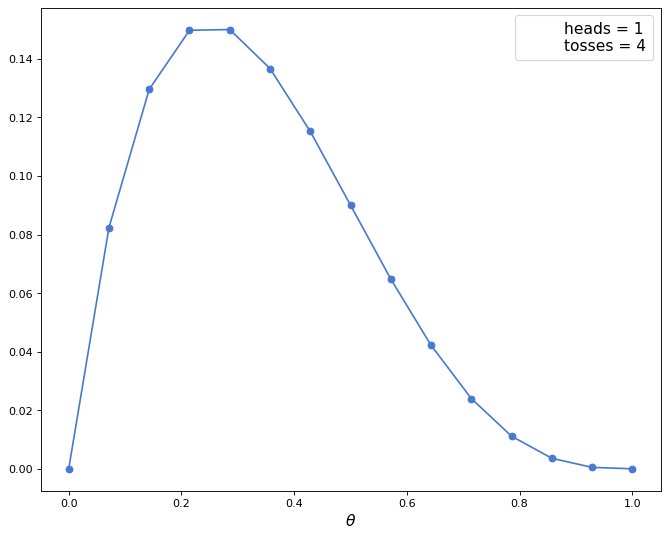

In [3]:
points, h, n = 15, 1, 4
grid, posterior = posterior_grid(points, h, n)
plt.figure(figsize=(10, 8), dpi=80)

plt.plot(grid, posterior, 'o-')
plt.plot(0, 0, label=f'heads = {h}\ntosses = {n}', alpha=0)
plt.xlabel(r'$\theta$', fontsize=14)
plt.legend(loc=0, fontsize=14)


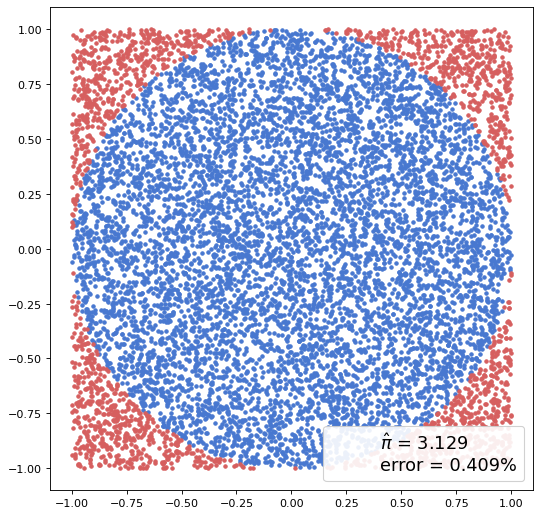

In [4]:
# Monte Carlo in PI
N = 10000

x, y = np.random.uniform(-1, 1, size=(2, N))

inside = (x**2 + y**2)  <= 1
pi = inside.sum()*4/N
error = abs((pi - np.pi)/pi)* 100

outside = np.invert(inside)

plt.figure(figsize=(10, 8), dpi=80)

plt.plot(x[inside], y[inside], 'b.')
plt.plot(x[outside], y[outside], 'r.')

plt.plot(0, 0, label='$\hat \pi$ = {:4.3f}\nerror = {:4.3f}%'.format(pi, error), alpha=0)
plt.axis('square')
plt.legend(frameon=True, framealpha=0.9, fontsize=16)

In [5]:
# Metropolis
def metropolis(func, steps=10000):
    """A very simple Metropolis implementation"""
    samples = np.zeros(steps)

    old_x = func.mean()
    old_prob = func.pdf(old_x)

    for i in range(steps):
        new_x = old_x + np.random.normal(0, 1)
        new_prob = func.pdf(new_x)

        acceptance = new_prob/old_prob
        
        if acceptance >= np.random.random():
            samples[i] = new_x
            old_x = new_x
            old_prob = new_prob
        else:
            samples[i] = old_x
    return samples


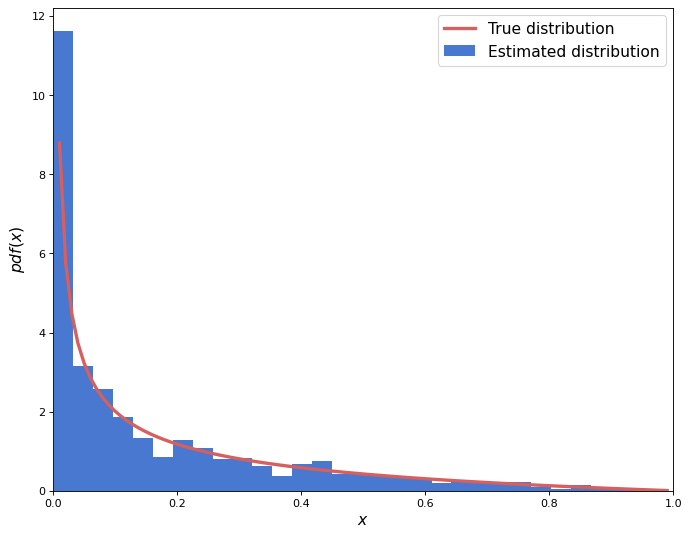

In [6]:
np.random.seed(345)

func = stats.beta(0.4, 2)
# '''
samples = metropolis(func=func)

x = np.linspace(0.01, .99, 100)
y = func.pdf(x)
plt.figure(figsize=(10, 8), dpi=80)
plt.xlim(0, 1)
plt.plot(x, y, 'r-', lw=3, label='True distribution')

plt.hist(samples, bins=30, density=True,
         stacked=True, label='Estimated distribution')
plt.xlabel('$x$', fontsize=14)
plt.ylabel('$pdf(x)$', fontsize=14)
plt.legend(fontsize=14)
# '''


In [7]:
# PYMC3
np.random.seed(123)
n_experiments = 4
theta_real = 0.35  # unkwon value in a real experiment
data = stats.bernoulli.rvs(p=theta_real, size=n_experiments)
data

array([1, 0, 0, 0])

In [8]:
with pm.Model() as our_first_model:
    # a priori
    theta = pm.Beta('theta', alpha=1, beta=1)
    # likelihood
    y = pm.Bernoulli('y', p=theta, observed=data)
    #y = pm.Binomial('theta',n=n_experimentos, p=theta, observed=sum(datos))
    start = pm.find_MAP()
    step = pm.Metropolis()
    trace = pm.sample(1000, step=step, start=start)

e:\Code\Algorithmic-Trading\env\lib\site-packages\ipykernel_launcher.py:9: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  if __name__ == '__main__':
Multiprocess sampling (2 chains in 2 jobs)
Metropolis: [theta]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 14 seconds.
The number of effective samples is smaller than 25% for some parameters.


e:\Code\Algorithmic-Trading\env\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  This is separate from the ipykernel package so we can avoid doing imports until
Got error No model on context stack. trying to find log_likelihood in translation.
e:\Code\Algorithmic-Trading\env\lib\site-packages\arviz\data\io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
Got error No model on context stack. trying to find log_likelihood in translation.
e:\Code\Algorithmic-Trading\env\lib\site-packages\arviz\plots\backends\matplotlib\traceplot.py:216: UserWarning: A valid var_name should be provided, found {'t'} expected from

array([[<AxesSubplot:title={'center':'theta'}>,
        <AxesSubplot:title={'center':'theta'}>]], dtype=object)

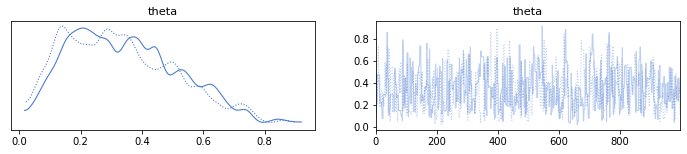

In [9]:
burnin = 0  # no burnin
chain = trace[burnin:]
pm.traceplot(chain, lines={'theta_':theta_real})

In [11]:
with our_first_model:
    step = pm.Metropolis()
    # how to generate multi_trace
    multi_trace = pm.sample(1000, step=step)    # , njobs=4

e:\Code\Algorithmic-Trading\env\lib\site-packages\ipykernel_launcher.py:4: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  after removing the cwd from sys.path.
Multiprocess sampling (2 chains in 2 jobs)
Metropolis: [theta]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 15 seconds.
The number of effective samples is smaller than 25% for some parameters.


e:\Code\Algorithmic-Trading\env\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  This is separate from the ipykernel package so we can avoid doing imports until
Got error No model on context stack. trying to find log_likelihood in translation.
e:\Code\Algorithmic-Trading\env\lib\site-packages\arviz\data\io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,
Got error No model on context stack. trying to find log_likelihood in translation.
e:\Code\Algorithmic-Trading\env\lib\site-packages\arviz\plots\backends\matplotlib\traceplot.py:216: UserWarning: A valid var_name should be provided, found {'t'} expected from

array([[<AxesSubplot:title={'center':'theta'}>,
        <AxesSubplot:title={'center':'theta'}>]], dtype=object)

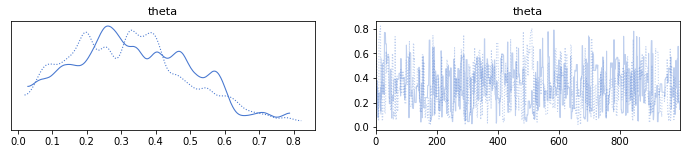

In [12]:
burnin = 0  # no burnin
multi_chain = multi_trace[burnin:]
pm.traceplot(multi_chain, lines={'theta':theta_real})

Got error No model on context stack. trying to find log_likelihood in translation.
e:\Code\Algorithmic-Trading\env\lib\site-packages\arviz\data\io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

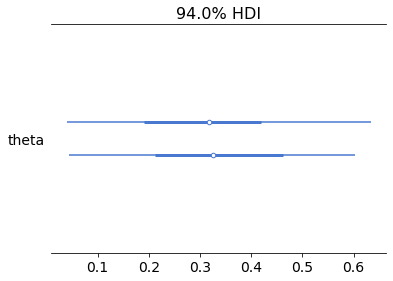

In [15]:
az.plot_forest(multi_chain, var_names=['theta'])

In [16]:
pm.summary(multi_chain)

Got error No model on context stack. trying to find log_likelihood in translation.
e:\Code\Algorithmic-Trading\env\lib\site-packages\arviz\data\io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta,0.329,0.17,0.039,0.616,0.008,0.006,417.0,650.0,1.0


e:\Code\Algorithmic-Trading\env\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: The function `autocorrplot` from PyMC3 is just an alias for `plot_autocorr` from ArviZ. Please switch to `pymc3.plot_autocorr` or `arviz.plot_autocorr`.
  """Entry point for launching an IPython kernel.
Got error No model on context stack. trying to find log_likelihood in translation.
e:\Code\Algorithmic-Trading\env\lib\site-packages\arviz\data\io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([<AxesSubplot:title={'center':'theta\n0'}>,
       <AxesSubplot:title={'center':'theta\n1'}>], dtype=object)

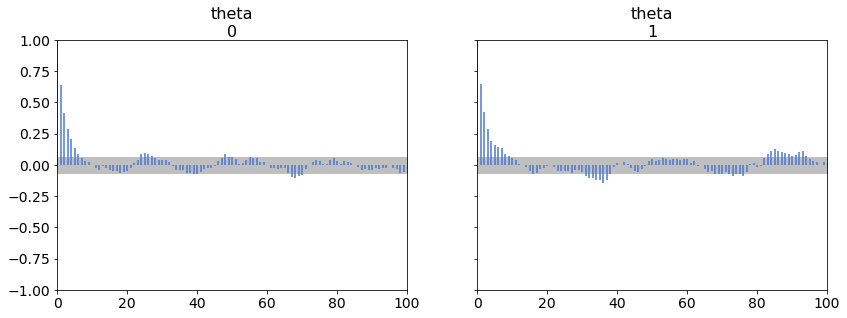

In [17]:
pm.autocorrplot(chain)

Got error No model on context stack. trying to find log_likelihood in translation.
e:\Code\Algorithmic-Trading\env\lib\site-packages\arviz\data\io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


<AxesSubplot:title={'center':'theta'}>

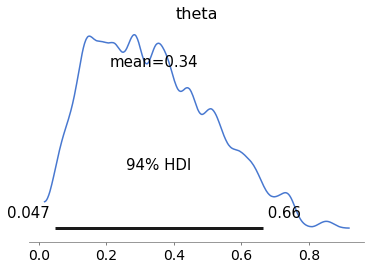

In [20]:
pm.plot_posterior(chain, kind='kde')

Got error No model on context stack. trying to find log_likelihood in translation.
e:\Code\Algorithmic-Trading\env\lib\site-packages\arviz\data\io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


<AxesSubplot:title={'center':'theta'}>

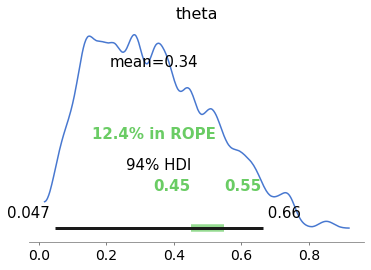

In [21]:
pm.plot_posterior(chain, kind='kde', rope=[0.45, .55])

Got error No model on context stack. trying to find log_likelihood in translation.
e:\Code\Algorithmic-Trading\env\lib\site-packages\arviz\data\io_pymc3_3x.py:102: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


<AxesSubplot:title={'center':'theta'}>

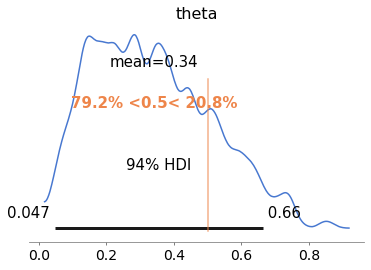

In [23]:
pm.plot_posterior(chain, kind='kde', ref_val=0.5)